In [3]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import cg
import matplotlib.pyplot as plt
import time

def extend_to_128x128x128(A):
    x, y, z = A.shape
    if x == 128 and y == 128 and z == 128:
        print("The matrix is already 128x128x128")
        return A
    else:
        rep_x = np.ceil(128 / x).astype(int)
        rep_y = np.ceil(128 / y).astype(int)
        rep_z = np.ceil(128 / z).astype(int)

        B = np.tile(A, (rep_x, rep_y, rep_z))
        B = B[:128, :128, :128]

        print("The matrix has been extended to 128x128x128")
        return B

# Parameters
n = [128, 128, 128]
nx, ny, nz = n
lamb = 1e-3

# Simulate nx * ny * nz surface coil phantom (using 2D Shepp-Logan for simplicity)
temp = np.outer(np.arange(1, nx + 1), np.ones(ny))
x3_s = np.tile(temp[:, :, np.newaxis], (1, 1, nz))

# Simulate body coil image
x3_b = np.abs(x3_s) ** 0.5


In [5]:

# Extend matrices
x3_b = extend_to_128x128x128(x3_b)
x3_s = extend_to_128x128x128(x3_s)

start_time = time.time()

# Convert x3_s into a sparse diagonal matrix
A = sp.diags(x3_s.flatten())

# Create differential operators
D1 = sp.diags([1, -1], [0, 1], (nx, nx)).tolil()
D1[-1, 0] = -1
D2 = sp.diags([1, -1], [0, 1], (ny, ny)).tolil()
D2[-1, 0] = -1
D3 = sp.diags([1, -1], [0, 1], (nz, nz)).tolil()
D3[-1, 0] = -1

# Create the 3D differential operator
D = sp.block_diag([sp.kron(sp.kron(sp.eye(nz), sp.eye(ny)), D1),
                   sp.kron(sp.kron(sp.eye(nz), D2), sp.eye(nx)),
                   sp.kron(sp.kron(D3, sp.eye(ny)), sp.eye(nx))])

#debug
print("Shape of A.T @ A:", (A.T @ A).shape)
print("Shape of D.T @ D:", (D.T @ D).shape)


The matrix is already 128x128x128
The matrix is already 128x128x128
Shape of A.T @ A: (2097152, 2097152)
Shape of D.T @ D: (6291456, 6291456)


In [ ]:

# Regularized least-squares solution
B = A.T @ A + lamb * D.T @ D

# Solve for c using CG method
c, _ = cg(B, A.T @ x3_b.flatten(), tol=1e-4, maxiter=500)
c = c.reshape(nx, ny, nz)

x3_sc = c * x3_s

print(f"Time to apply correction is: {time.time() - start_time:.3f} s")

# Plotting
plt.figure()
plt.subplot(2, 2, 1)
plt.imshow(np.squeeze(x3_s[:, ny // 2, :]), cmap="gray")
plt.axis("off")
plt.title("surface coil")

plt.subplot(2, 2, 2)
plt.imshow(np.squeeze(x3_b[:, ny // 2, :]), cmap="gray")
plt.axis("off")
plt.title("body coil")

plt.subplot(2, 2, 3)
plt.imshow(np.squeeze(c[:, ny // 2, :]), cmap="jet")
plt.axis("off")
plt.title("correction map")

plt.subplot(2, 2, 4)
plt.imshow(np.squeeze(x3_sc[:, ny // 2, :]), cmap="gray")
plt.axis("off")
plt.title("corrected")

plt.show()


In [ ]:
import numpy as np
import scipy.sparse as sp
import time
import matplotlib.pyplot as plt
from scipy.sparse.linalg import cg

def extendTo128x128x128(A):
    x, y, z = A.shape

    if x == 128 and y == 128 and z == 128:
        print("The matrix is already 128x128x128")
        return A
    else:
        rep_x = -(-128 // x)  # Equivalent to ceil(128 / x)
        rep_y = -(-128 // y)  # Equivalent to ceil(128 / y)
        rep_z = -(-128 // z)  # Equivalent to ceil(128 / z)

        B = np.repeat(A, rep_x, axis=0)
        B = np.repeat(B, rep_y, axis=1)
        B = np.repeat(B, rep_z, axis=2)

        B = B[:128, :128, :128]

        print("The matrix has been extended to 128x128x128")
        return B


# Parameters
n = [64, 32, 32]
nx, ny, nz = n
lamb = 1e-3

# Simulate nx * ny * nz surface coil phantom
# temp = np.zeros((nx, ny))  # Dummy data, replace with your own data
# x3_s = temp[:, :ny]
# x3_s = np.repeat(x3_s[:, :, np.newaxis], nz, axis=2)

# # Now simulate body coil image
# x3_b = np.abs(x3_s) ** 0.5
#load x3_s and x3_b from x3d.mat
import scipy.io as sio
mat_contents = sio.loadmat('x3d.mat')
x3_s = mat_contents['x3_b'][32:-32,::4,::4]
x3_b = mat_contents['x3_s'][32:-32,::4,::4]

print("Shape of x3_s:", x3_s.shape)
print("Shape of x3_b:", x3_b.shape)

# Assume extendTo128x128x128 function is defined
#x3_b = extendTo128x128x128(x3_b)
#x3_s = extendTo128x128x128(x3_s)

# Start timing
start_time = time.time()

# Convert x3_s into a sparse operator
A = sp.diags(x3_s.flatten())

# Construct differential operators for each dimension
D1 = sp.diags([1, -1], [0, 1], shape=(nx, nx)).tolil()  # Convert to LIL format
D1[-1, 0] = -1  # Modify the element
D1 = D1.todia()  # Convert back to DIA format if needed

D2 = sp.diags([1, -1], [0, 1], shape=(ny, ny)).tolil()
D2[-1, 0] = -1
D2 = D2.todia()

D3 = sp.diags([1, -1], [0, 1], shape=(nz, nz)).tolil()
D3[-1, 0] = -1
D3 = D3.todia()


# Construct the differential operator for the entire 3D image
D = sp.vstack([
    sp.kron(sp.kron(sp.eye(nz), sp.eye(ny)), D1),
    sp.kron(sp.kron(sp.eye(nz), D2), sp.eye(nx)),
    sp.kron(sp.kron(D3, sp.eye(ny)), sp.eye(nx))
])

# Regularized least-squares solution
B = (A.T @ A + lamb * D.T @ D)
c, _ = cg(B, A.T @ x3_b.flatten(), tol=1e-4, maxiter=500)
c = c.reshape((nx, ny, nz))
x3_sc = c * x3_s

# Print time
print(f"Time to apply correction is: {time.time() - start_time:.3f} s")
# Plotting
plt.figure(figsize=(5, 10))
plt.subplot(2, 2, 1)
plt.imshow(np.squeeze(x3_s[:, ny//2, :]), cmap='gray')
plt.axis('off')
plt.title('surface coil')

plt.subplot(2, 2, 2)
plt.imshow(np.squeeze(x3_b[:, ny//2, :]), cmap='gray')
plt.axis('off')
plt.title('body coil')

plt.subplot(2, 2, 3)
plt.imshow(np.squeeze(c[:, ny//2, :]), cmap='jet')
plt.axis('off')
plt.title('correction map')
#plt.colorbar()

plt.subplot(2, 2, 4)
plt.imshow(np.squeeze(x3_sc[:, ny//2, :]), cmap='gray')
plt.axis('off')
plt.title('corrected')

plt.show()

In [ ]:
#load x3_s and x3_b from x3d.mat
import scipy.io as sio
mat_contents = sio.loadmat('x3d.mat')
x3_s = mat_contents['x3_s'][32:-32,::4,::4]
x3_b = mat_contents['x3_b'][32:-32,::4,::4]

In [27]:
import numpy as np
import scipy.sparse as sp
import time
import matplotlib.pyplot as plt
from scipy.sparse.linalg import cg

#normalize x3_s and x3_b with the maximum value of x3_s
def correction_map_solver_3D(x3_s_in, x3_b_in, sensitivity_correction_maps=False, debug = False):

    if sensitivity_correction_maps:
        #exchange x3_s and x3_b for finding the sensitivity correction map
        x3_s = x3_b_in/np.max(x3_b_in)
        x3_b = x3_s_in/np.max(x3_b_in)
    else:
        x3_s = x3_s_in/np.max(x3_s_in)
        x3_b = x3_b_in/np.max(x3_b_in)

    if debug:
        print("Shape of x3_s:", x3_s.shape)
        print("Shape of x3_b:", x3_b.shape)

    assert x3_s.shape == x3_b.shape, "x3_s and x3_b must have the same shape"

    # Parameters
    n = x3_s.shape#[64, 32, 32]
    nx, ny, nz = n
    lamb = 1e-3

    # Start timing
    start_time = time.time()

    # Convert x3_s into a sparse operator
    A = sp.diags(x3_s.flatten())

    # Construct differential operators for each dimension
    D1 = sp.diags([1, -1], [0, 1], shape=(nx, nx)).tolil()  # Convert to LIL format
    D1[-1, 0] = -1  # Modify the element
    D1 = D1.todia()  # Convert back to DIA format if needed

    D2 = sp.diags([1, -1], [0, 1], shape=(ny, ny)).tolil()
    D2[-1, 0] = -1
    D2 = D2.todia()

    D3 = sp.diags([1, -1], [0, 1], shape=(nz, nz)).tolil()
    D3[-1, 0] = -1
    D3 = D3.todia()


    # Construct the differential operator for the entire 3D image
    D = sp.vstack([
    sp.kron(sp.kron(sp.eye(nz), sp.eye(ny)), D1),
    sp.kron(sp.kron(sp.eye(nz), D2), sp.eye(nx)),
    sp.kron(sp.kron(D3, sp.eye(ny)), sp.eye(nx))
    ])

    # Regularized least-squares solution
    B = (A.T @ A + lamb * D.T @ D)
    c, _ = cg(B, A.T @ x3_b.flatten(), tol=1e-4, maxiter=500)
    c = c.reshape((nx, ny, nz))

    x3_sc = c * x3_s
    
    if debug:
        # Print time
        print(f"Time to apply correction is: {time.time() - start_time:.3f} s")
        # Plotting
        plt.figure(figsize=(5, 10))
        plt.subplot(2, 2, 1)
        plt.imshow(np.squeeze(x3_s[:, ny//2, :]), cmap='gray')
        plt.axis('off')
        plt.title('surface coil')

        plt.subplot(2, 2, 2)
        plt.imshow(np.squeeze(x3_b[:, ny//2, :]), cmap='gray')
        plt.axis('off')
        plt.title('body coil')

        plt.subplot(2, 2, 3)
        plt.imshow(np.squeeze(c[:, ny//2, :]), cmap='jet')
        plt.axis('off')
        plt.title('correction map')
        #plt.colorbar()

        plt.subplot(2, 2, 4)
        plt.imshow(np.squeeze(x3_sc[:, ny//2, :]), cmap='gray')
        plt.axis('off')
        plt.title('corrected')

        plt.show()

    return c



Shape of x3_s: (64, 32, 32)
Shape of x3_b: (64, 32, 32)
Time to apply correction is: 4.368 s


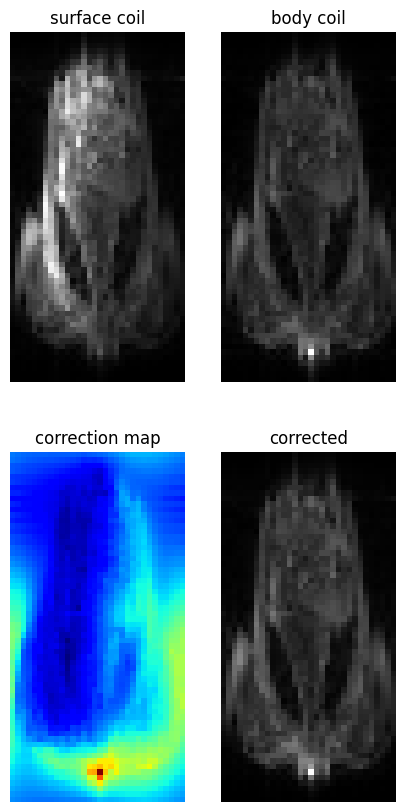

In [28]:
c = correction_map_solver_3D(x3_s, x3_b, debug=True)

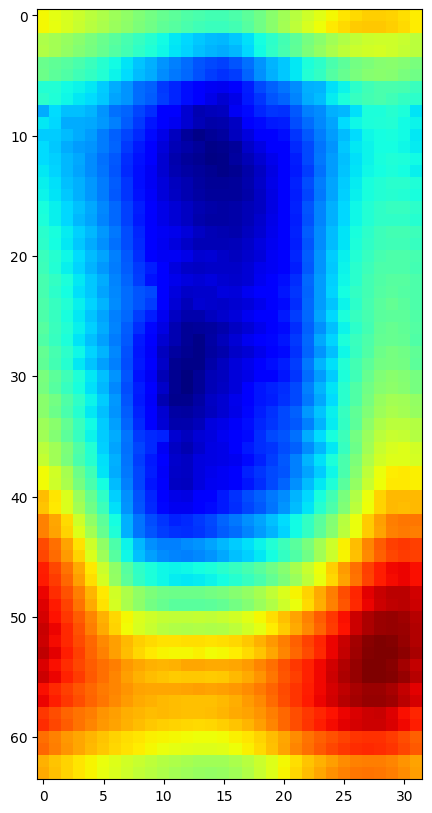

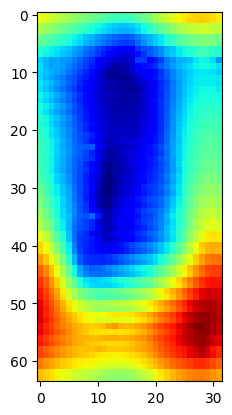

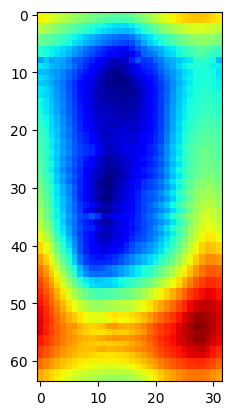

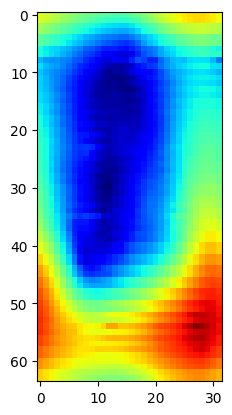

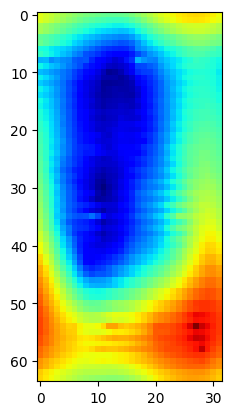

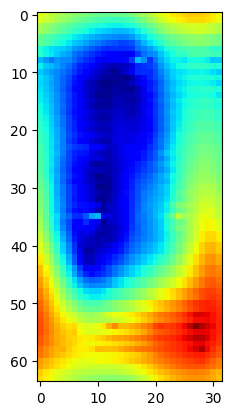

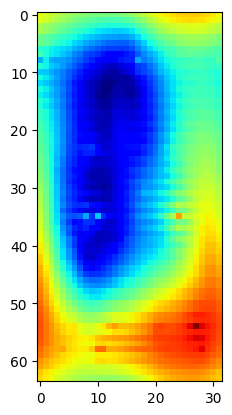

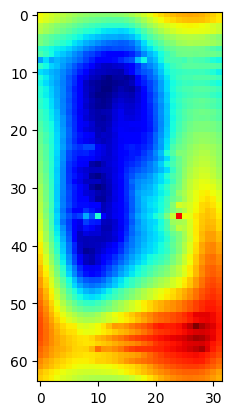

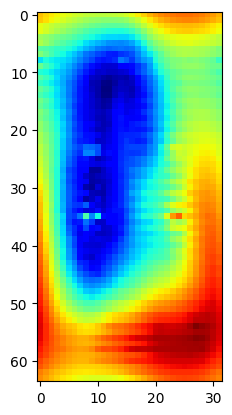

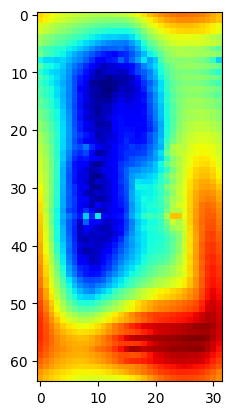

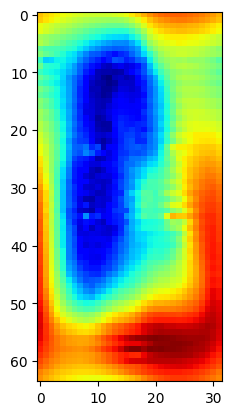

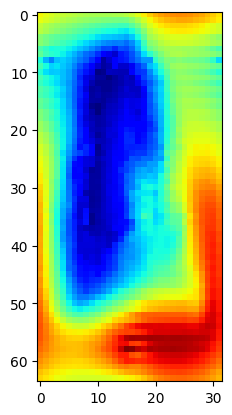

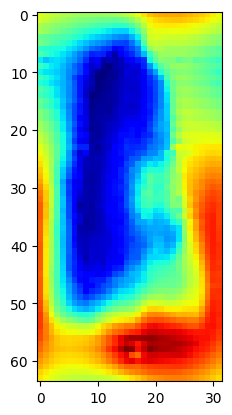

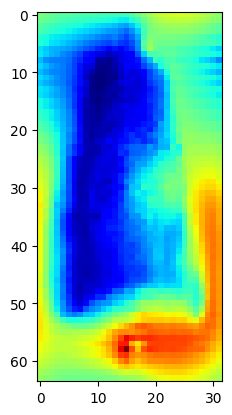

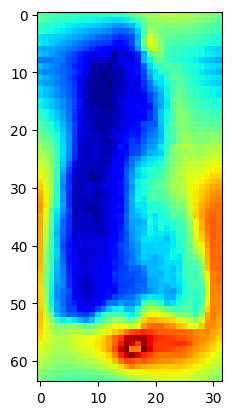

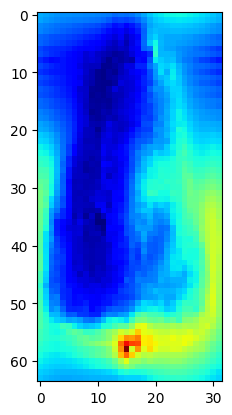

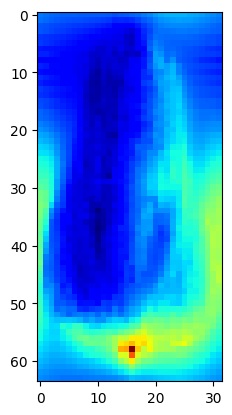

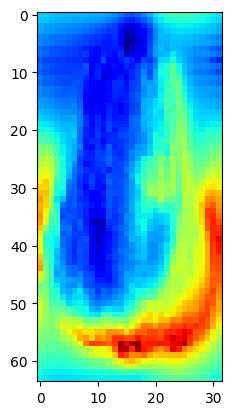

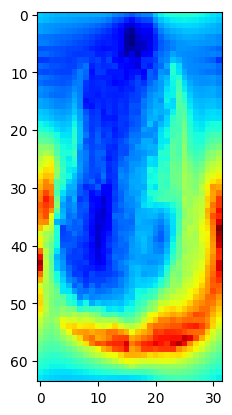

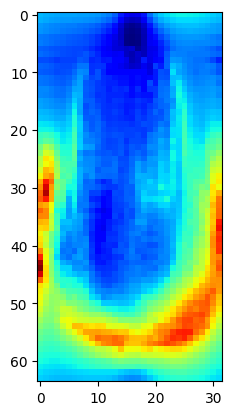

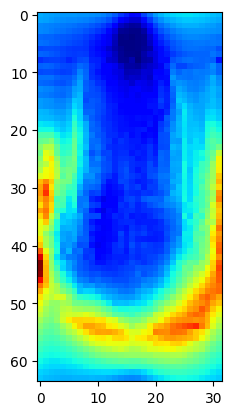

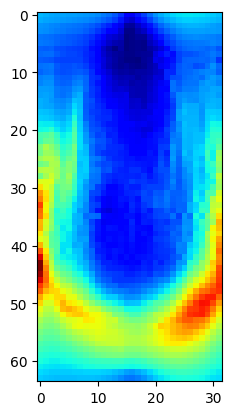

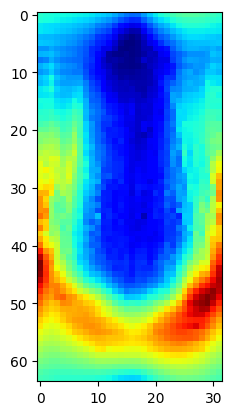

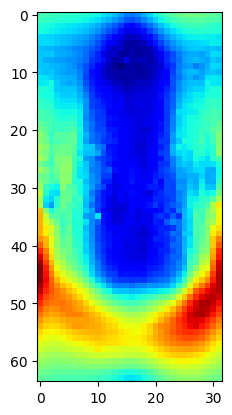

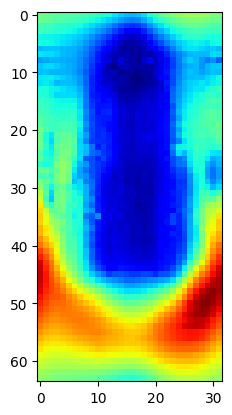

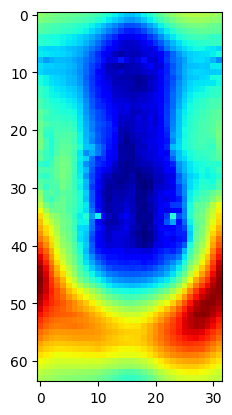

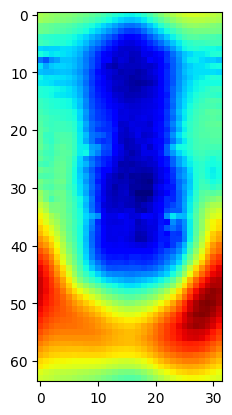

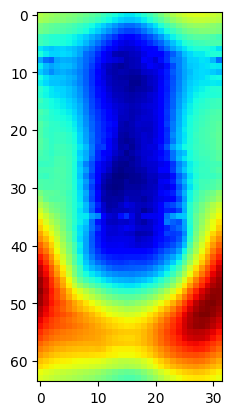

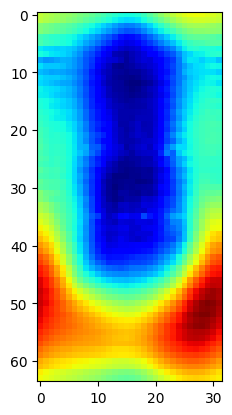

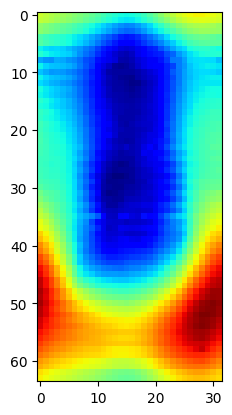

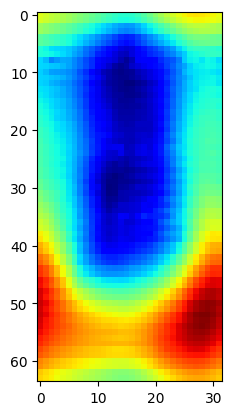

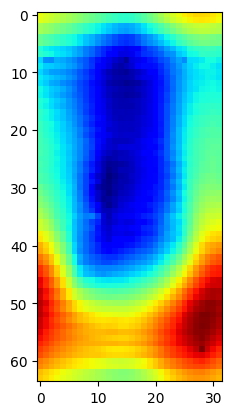

In [42]:
#plt c
plt.figure(figsize=(5, 10))
for i in range(c.shape[1]):
    plt.imshow(np.squeeze(c[:, i, :]), cmap='jet')
    plt.pause(0.1)

Shape of x3_s: (64, 32, 32)
Shape of x3_b: (64, 32, 32)
CG converged after 97 iterations.
Time to apply correction is: 7.100 s


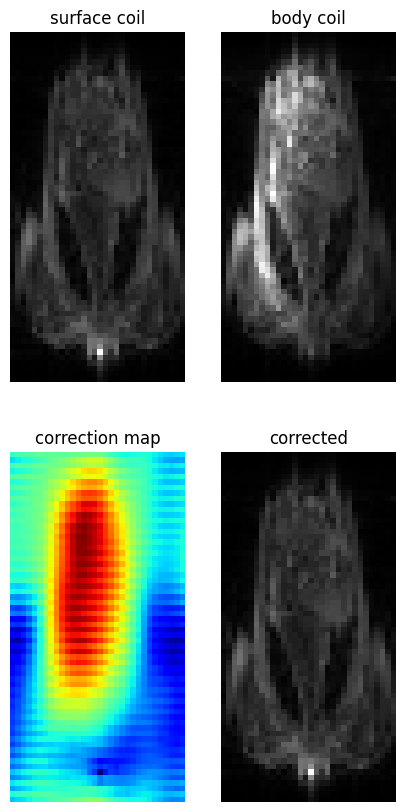

In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.io as sio
import time
import matplotlib.pyplot as plt
import torch

# Custom CG solver using PyTorch for GPU acceleration
def cg_gpu(A, b, tol=1e-4, maxiter=500):
    n = len(b)
    x = torch.zeros(n, dtype=torch.float32, device='cuda')
    r = b - A @ x
    p = r.clone()
    rsold = r @ r

    for i in range(maxiter):
        Ap = A @ p
        alpha = rsold / (p @ Ap)
        x += alpha * p
        r -= alpha * Ap
        rsnew = r @ r
        if torch.sqrt(rsnew) < tol:
            print(f'CG converged after {i} iterations.')
            return x.cpu()
        p = r + (rsnew / rsold) * p
        rsold = rsnew

    print('CG reached max iterations without converging.')
    return x.cpu()



# Load x3_s and x3_b from x3d.mat
mat_contents = sio.loadmat('x3d.mat')
x3_s = mat_contents['x3_b'][32:-32,::4,::4]
x3_b = mat_contents['x3_s'][32:-32,::4,::4]

# Parameters
n = x3_s.shape#[64, 32, 32]
nx, ny, nz = n
lamb = 1e-3

print("Shape of x3_s:", x3_s.shape)
print("Shape of x3_b:", x3_b.shape)

# Start timing
start_time = time.time()

# Convert x3_s into a sparse operator
A = sp.diags(x3_s.flatten())

# Construct differential operators for each dimension
D1 = sp.diags([1, -1], [0, 1], shape=(nx, nx)).tolil()
D1[-1, 0] = -1
D1 = D1.todia()

D2 = sp.diags([1, -1], [0, 1], shape=(ny, ny)).tolil()
D2[-1, 0] = -1
D2 = D2.todia()

D3 = sp.diags([1, -1], [0, 1], shape=(nz, nz)).tolil()
D3[-1, 0] = -1
D3 = D3.todia()

# Construct the differential operator for the entire 3D image
D = sp.vstack([
    sp.kron(sp.kron(sp.eye(nz), sp.eye(ny)), D1),
    sp.kron(sp.kron(sp.eye(nz), D2), sp.eye(nx)),
    sp.kron(sp.kron(D3, sp.eye(ny)), sp.eye(nx))
])

# Regularized least-squares solution
B = (A.T @ A + lamb * D.T @ D).tocsc()  # Convert to CSC for better performance

# Move B and A.T @ x3_b.flatten() to GPU and solve using CG
B_gpu = torch.tensor(B.toarray(), dtype=torch.float32).to('cuda')
b_gpu = torch.tensor(A.T @ x3_b.flatten(), dtype=torch.float32).to('cuda')
c = cg_gpu(B_gpu, b_gpu)

# Reshape and apply correction
c = c.reshape((nx, ny, nz))
x3_sc = c * x3_s

# Print time
print(f"Time to apply correction is: {time.time() - start_time:.3f} s")

# Plotting
plt.figure(figsize=(5, 10))
plt.subplot(2, 2, 1)
plt.imshow(np.squeeze(x3_s[:, ny//2, :]), cmap='gray')
plt.axis('off')
plt.title('surface coil')

plt.subplot(2, 2, 2)
plt.imshow(np.squeeze(x3_b[:, ny//2, :]), cmap='gray')
plt.axis('off')
plt.title('body coil')

plt.subplot(2, 2, 3)
plt.imshow(np.squeeze(c[:, ny//2, :]), cmap='jet')
plt.axis('off')
plt.title('correction map')

plt.subplot(2, 2, 4)
plt.imshow(np.squeeze(x3_sc[:, ny//2, :]), cmap='gray')
plt.axis('off')
plt.title('corrected')

plt.show()
